In [1]:
!pip install optuna -q
!pip install --upgrade datasets -q
!pip install --upgrade triton -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 9.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive') # mounting drive where files are stored

Mounted at /content/drive


In [3]:
import sys
path = "/content/drive/MyDrive/AI_Cybersecurity/Project/"
sys.path.append(path)

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F # loading libraries
from sklearn.datasets import load_iris
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_from_disk
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from contextlib import nullcontext
from utils import BPE_Tokenizer, Transformer, train_model, test_model, run_inference_and_collect_results, calculate_auc_roc, plot_confusion_matrix, test_model_adversarial, run_inference_and_collect_results_adversarial, multiples_of_two

In [5]:
torch.set_float32_matmul_precision('high')

In [6]:
tokenizer = BPE_Tokenizer(directory=path+'Tokenizer')
vocab = tokenizer.vocab
vocab_size = len(vocab) + 1
print("Vocab size is", vocab_size)

Vocab size is 10007


In [7]:
tokenized_dataset = load_from_disk(path+"Datasets/FinalDataset/")

In [8]:
train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['validation']
test_dataset = tokenized_dataset['test']

In [9]:
batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vector_length = 1024
num_blocks = 1
num_heads = 4
dropout = 0.2
metadata_vector_length = 1024
num_metadata_features = len(train_dataset['metadata'][0])
max_context_size = 256
num_epochs = 1
max_lr = 2e-4
scheduler_config = {"warmup_steps": 5,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": max_lr,
                    "min_lr": max_lr * 0.1}

In [11]:
# Initialize the model for binary classification of class 0
model = Transformer(vocab_size, vector_length, max_context_size, num_blocks, num_heads, dropout, num_metadata_features, metadata_vector_length).to(device)

# Test the model with the initial untrained state and compute training loss
for batch in train_loader:
    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    metadata = batch["metadata"].to(device)
    labels = batch["label"].to(device)
    logits, _ = model(inputs, attention_mask, metadata, labels)  # Forward pass through the model
    print(logits.shape)
    break

torch.cuda.empty_cache()

loss = test_model(model, train_loader, fp16=True, device="cuda")  # Compute the loss on the training dataset
print(f"Initial Training Loss {loss:.4f}")

torch.Size([128, 2])
Initial Training Loss 0.7237


In [12]:
def objective(trial):
    # Define hyperparameters to optimize
    vector_length = trial.suggest_categorical("vector_length", multiples_of_two(128, 2048))
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_heads = trial.suggest_categorical("num_heads", multiples_of_two(2, 8))
    num_epochs = trial.suggest_int("num_epochs", 1, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    metadata_vector_length = trial.suggest_categorical("metadata_vector_length", multiples_of_two(128, 2048))
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    warmup_steps = trial.suggest_int("warmup_steps", 10, 100, step=10)

    # Create the model
    model = Transformer(
        vocab_size=10240,
        vector_length=vector_length,
        context_size=max_context_size,
        num_blocks=num_blocks,
        num_heads=num_heads,
        dropout=dropout,
        padding_idx=tokenizer.padding_idx,
        num_metadata_features=num_metadata_features,
        metadata_vector_length=metadata_vector_length,
        num_classes=2
    ).to(device)
    model = torch.compile(model)

    # Optimizer
    optimizer = model.configure_optimizers(weight_decay=0.01, learning_rate=lr, device_type=device)

    scheduler_config = {"warmup_steps": warmup_steps,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": lr,
                    "min_lr": lr * 0.1}

    # Train the model
    model = train_model(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        num_epochs=num_epochs,
        optimizer=optimizer,
        device=device,
        fp16=True,
        scheduler_config=scheduler_config,
        log_interval=10,
        early_stopping=True,
    )

    # Evaluate on the validation set
    val_loss = test_model(model, val_loader, device, fp16=True)

    # Return the validation loss as the objective to minimize
    return val_loss

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Run the optimization
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

[I 2024-12-06 15:13:40,017] A new study created in memory with name: no-name-6face86c-7840-468f-9371-bc966a4347d2


Num decayed parameter tensors: 9, with 24,435,712 parameters
Num non-decayed parameter tensors: 13, with 17,410 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6846, Average Validation Loss: 0.6805, Accuracy: 63.37%, Precision: 47.74%, Recall: 80.18%, F1: 0.60
Epoch 0, Average Training Loss: 0.6785, Average Validation Loss: 0.6641, Accuracy: 73.08%, Precision: 88.26%, Recall: 71.41%, F1: 0.79
Epoch 0, Average Training Loss: 0.6568, Average Validation Loss: 0.6428, Accuracy: 63.68%, Precision: 99.52%, Recall: 61.23%, F1: 0.76
Epoch 0, Average Training Loss: 0.6340, Average Validation Loss: 0.6212, Accuracy: 59.37%, Precision: 99.96%, Recall: 58.47%, F1: 0.74
Epoch 0, Average Training Loss: 0.6103, Average Validation Loss: 0.5985, Accuracy: 59.29%, Precision: 99.98%, Recall: 58.42%, F1: 0.74
Epoch 0, Average Training Loss: 0.5853, Average Validation Loss: 0.5720, Accuracy: 60.93%, Precision: 99.99%, Recall: 59.41%, F1: 0.75
Epoch 0, Average Training Loss: 0.5580, Ave

[I 2024-12-06 15:20:42,028] Trial 0 finished with value: 0.08501243356653061 and parameters: {'vector_length': 1024, 'num_blocks': 1, 'num_heads': 4, 'num_epochs': 5, 'dropout': 0.4, 'metadata_vector_length': 1024, 'lr': 7.471456961536299e-06, 'warmup_steps': 90}. Best is trial 0 with value: 0.08501243356653061.


Num decayed parameter tensors: 17, with 49,601,536 parameters
Num non-decayed parameter tensors: 29, with 44,034 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6876, Average Validation Loss: 0.6699, Accuracy: 57.17%, Precision: 99.95%, Recall: 57.19%, F1: 0.73
Epoch 0, Average Training Loss: 0.6391, Average Validation Loss: 0.6313, Accuracy: 57.35%, Precision: 99.96%, Recall: 57.28%, F1: 0.73
Epoch 0, Average Training Loss: 0.6025, Average Validation Loss: 0.5636, Accuracy: 69.68%, Precision: 99.96%, Recall: 65.37%, F1: 0.79
Epoch 0, Average Training Loss: 0.5469, Average Validation Loss: 0.5430, Accuracy: 62.95%, Precision: 99.99%, Recall: 60.69%, F1: 0.76
Epoch 0, Average Training Loss: 0.5140, Average Validation Loss: 0.4882, Accuracy: 74.02%, Precision: 99.99%, Recall: 68.76%, F1: 0.81
Epoch 0, Average Training Loss: 0.4830, Average Validation Loss: 0.4423, Accuracy: 84.26%, Precision: 99.99%, Recall: 78.42%, F1: 0.88
Epoch 0, Average Training Loss: 0.4459, Av

W1206 15:27:08.604000 523 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1206 15:27:08.604000 523 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/content/drive/MyDrive/AI_Cybersecurity/Project/utils.py:777)
W1206 15:27:08.604000 523 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/1: GLOBAL_STATE changed: grad_mode 
W1206 15:27:08.604000 523 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1206 15:27:08.604000 523 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
[I 2024-12-06 15:27:08,613] Trial 1 finished with value: 0.30669411376521394 and parameters: {'vector_length': 1024, 'num_blocks': 3, 'num_heads': 8, 'num_epochs': 5, 'dropout': 0.4, 'metadata_vector_length': 1024, 'lr': 6.351891365972909e-06, 'warmup_steps': 10}. Best is trial 0 with value: 0.08501243356

Num decayed parameter tensors: 13, with 4,339,456 parameters
Num non-decayed parameter tensors: 21, with 7,682 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7384, Average Validation Loss: 0.7291, Accuracy: 23.89%, Precision: 34.67%, Recall: 33.85%, F1: 0.34
Epoch 0, Average Training Loss: 0.7214, Average Validation Loss: 0.7009, Accuracy: 57.13%, Precision: 99.83%, Recall: 57.17%, F1: 0.73
Epoch 0, Average Training Loss: 0.6949, Average Validation Loss: 0.6736, Accuracy: 57.20%, Precision: 99.96%, Recall: 57.20%, F1: 0.73
Epoch 0, Average Training Loss: 0.6630, Average Validation Loss: 0.6289, Accuracy: 59.18%, Precision: 99.96%, Recall: 58.36%, F1: 0.74
Epoch 0, Average Training Loss: 0.6091, Average Validation Loss: 0.5876, Accuracy: 59.51%, Precision: 99.99%, Recall: 58.55%, F1: 0.74
Epoch 0, Average Training Loss: 0.5627, Average Validation Loss: 0.5278, Accuracy: 71.54%, Precision: 100.00%, Recall: 66.77%, F1: 0.80
Epoch 0, Average Training Loss: 0.4995, Ave

[I 2024-12-06 15:30:04,652] Trial 2 finished with value: 0.04401034031698883 and parameters: {'vector_length': 256, 'num_blocks': 2, 'num_heads': 2, 'num_epochs': 2, 'dropout': 0.4, 'metadata_vector_length': 256, 'lr': 7.39852280408785e-05, 'warmup_steps': 70}. Best is trial 2 with value: 0.04401034031698883.


Num decayed parameter tensors: 9, with 3,553,024 parameters
Num non-decayed parameter tensors: 13, with 4,354 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7280, Average Validation Loss: 0.7240, Accuracy: 23.08%, Precision: 8.34%, Recall: 16.30%, F1: 0.11
Epoch 0, Average Training Loss: 0.7226, Average Validation Loss: 0.7230, Accuracy: 23.02%, Precision: 9.89%, Recall: 18.19%, F1: 0.13
Epoch 0, Average Training Loss: 0.7214, Average Validation Loss: 0.7213, Accuracy: 22.95%, Precision: 12.62%, Recall: 21.05%, F1: 0.16
Epoch 0, Average Training Loss: 0.7232, Average Validation Loss: 0.7190, Accuracy: 23.72%, Precision: 17.46%, Recall: 25.56%, F1: 0.21
Epoch 0, Average Training Loss: 0.7179, Average Validation Loss: 0.7160, Accuracy: 26.64%, Precision: 25.90%, Recall: 32.35%, F1: 0.29
Epoch 0, Average Training Loss: 0.7146, Average Validation Loss: 0.7126, Accuracy: 32.13%, Precision: 38.03%, Recall: 40.14%, F1: 0.39
Epoch 0, Average Training Loss: 0.7121, Average

[I 2024-12-06 15:45:02,628] Trial 3 finished with value: 0.43941709077036056 and parameters: {'vector_length': 256, 'num_blocks': 1, 'num_heads': 8, 'num_epochs': 1, 'dropout': 0.2, 'metadata_vector_length': 256, 'lr': 3.5121611335096927e-06, 'warmup_steps': 100}. Best is trial 2 with value: 0.04401034031698883.


Num decayed parameter tensors: 9, with 1,723,008 parameters
Num non-decayed parameter tensors: 13, with 3,074 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6308, Average Validation Loss: 0.5283, Accuracy: 87.59%, Precision: 99.96%, Recall: 82.19%, F1: 0.90
Epoch 0, Average Training Loss: 0.4068, Average Validation Loss: 0.2602, Accuracy: 98.67%, Precision: 99.62%, Recall: 98.09%, F1: 0.99
Epoch 0, Average Training Loss: 0.1784, Average Validation Loss: 0.1140, Accuracy: 99.11%, Precision: 99.26%, Recall: 99.19%, F1: 0.99
Epoch 0, Average Training Loss: 0.0898, Average Validation Loss: 0.0600, Accuracy: 99.34%, Precision: 99.56%, Recall: 99.29%, F1: 0.99
Epoch 0, Average Training Loss: 0.0518, Average Validation Loss: 0.0381, Accuracy: 99.48%, Precision: 99.70%, Recall: 99.39%, F1: 1.00
Epoch 0, Average Training Loss: 0.0305, Average Validation Loss: 0.0275, Accuracy: 99.58%, Precision: 99.77%, Recall: 99.49%, F1: 1.00
Epoch 0, Average Training Loss: 0.0249, Avera

[I 2024-12-06 15:47:45,753] Trial 4 finished with value: 0.0019219860409361285 and parameters: {'vector_length': 128, 'num_blocks': 1, 'num_heads': 8, 'num_epochs': 5, 'dropout': 0.1, 'metadata_vector_length': 1024, 'lr': 0.00022661022513990387, 'warmup_steps': 20}. Best is trial 4 with value: 0.0019219860409361285.


Num decayed parameter tensors: 9, with 4,101,376 parameters
Num non-decayed parameter tensors: 13, with 6,146 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6587, Average Validation Loss: 0.5936, Accuracy: 92.77%, Precision: 97.37%, Recall: 90.67%, F1: 0.94
Epoch 0, Average Training Loss: 0.5106, Average Validation Loss: 0.3963, Accuracy: 93.56%, Precision: 99.87%, Recall: 89.97%, F1: 0.95
Epoch 0, Average Training Loss: 0.3153, Average Validation Loss: 0.2131, Accuracy: 98.22%, Precision: 99.69%, Recall: 97.27%, F1: 0.98
Epoch 0, Average Training Loss: 0.1647, Average Validation Loss: 0.1165, Accuracy: 99.17%, Precision: 99.33%, Recall: 99.22%, F1: 0.99
Epoch 0, Average Training Loss: 0.0942, Average Validation Loss: 0.0743, Accuracy: 99.33%, Precision: 99.61%, Recall: 99.21%, F1: 0.99
Epoch 0, Average Training Loss: 0.0737, Average Validation Loss: 0.0542, Accuracy: 99.44%, Precision: 99.81%, Recall: 99.21%, F1: 1.00
Epoch 0, Average Training Loss: 0.0495, Avera

[I 2024-12-06 15:50:56,462] Trial 5 finished with value: 0.004531388479675091 and parameters: {'vector_length': 256, 'num_blocks': 1, 'num_heads': 8, 'num_epochs': 2, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 7.191901791978916e-05, 'warmup_steps': 30}. Best is trial 4 with value: 0.0019219860409361285.


Num decayed parameter tensors: 13, with 1,760,128 parameters
Num non-decayed parameter tensors: 21, with 3,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7137, Average Validation Loss: 0.7183, Accuracy: 34.39%, Precision: 52.33%, Recall: 43.84%, F1: 0.48
Epoch 0, Average Training Loss: 0.7162, Average Validation Loss: 0.7179, Accuracy: 34.94%, Precision: 53.71%, Recall: 44.32%, F1: 0.49
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.7218, Average Validation Loss: 0.7172, Accuracy: 35.91%, Precision: 55.89%, Recall: 45.13%, F1: 0.50
Epoch 0, Average Training Loss: 0.7143, Average Validation Loss: 0.7164, Accuracy: 37.16%, Precision: 58.60%, Recall: 46.12%, F1: 0.52
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.7186, Average Validation Loss: 0.7153, Accuracy: 38.98%, Precision: 62.51%, Recall: 47.46%, F1: 0.54
Epoch 0, Average Training Loss: 0.7106, Average Validatio

[I 2024-12-06 16:33:43,305] Trial 6 finished with value: 0.07074965492293642 and parameters: {'vector_length': 128, 'num_blocks': 2, 'num_heads': 2, 'num_epochs': 3, 'dropout': 0.1, 'metadata_vector_length': 128, 'lr': 2.478348022388534e-06, 'warmup_steps': 90}. Best is trial 4 with value: 0.0019219860409361285.


Num decayed parameter tensors: 9, with 3,788,032 parameters
Num non-decayed parameter tensors: 13, with 5,122 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6998, Average Validation Loss: 0.6539, Accuracy: 85.63%, Precision: 83.05%, Recall: 91.04%, F1: 0.87
Epoch 0, Average Training Loss: 0.5936, Average Validation Loss: 0.5211, Accuracy: 85.27%, Precision: 100.00%, Recall: 79.52%, F1: 0.89
Epoch 0, Average Training Loss: 0.4562, Average Validation Loss: 0.3661, Accuracy: 95.00%, Precision: 99.97%, Recall: 91.98%, F1: 0.96
Epoch 0, Average Training Loss: 0.3095, Average Validation Loss: 0.2226, Accuracy: 99.13%, Precision: 99.55%, Recall: 98.95%, F1: 0.99
Epoch 0, Average Training Loss: 0.1698, Average Validation Loss: 0.1263, Accuracy: 99.28%, Precision: 99.64%, Recall: 99.11%, F1: 0.99
Epoch 0, Average Training Loss: 0.0988, Average Validation Loss: 0.0728, Accuracy: 99.43%, Precision: 99.76%, Recall: 99.25%, F1: 1.00
Epoch 0, Average Training Loss: 0.0559, Aver

[I 2024-12-06 16:35:52,828] Trial 7 finished with value: 0.0036780581474886278 and parameters: {'vector_length': 256, 'num_blocks': 1, 'num_heads': 8, 'num_epochs': 5, 'dropout': 0.1, 'metadata_vector_length': 1024, 'lr': 0.0001734508801688089, 'warmup_steps': 70}. Best is trial 4 with value: 0.0019219860409361285.


Num decayed parameter tensors: 21, with 18,103,296 parameters
Num non-decayed parameter tensors: 37, with 28,418 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6880, Average Validation Loss: 0.6802, Accuracy: 57.24%, Precision: 99.96%, Recall: 57.22%, F1: 0.73
Epoch 0, Average Training Loss: 0.6294, Average Validation Loss: 0.5744, Accuracy: 66.25%, Precision: 99.93%, Recall: 62.90%, F1: 0.77
Epoch 0, Average Training Loss: 0.5717, Average Validation Loss: 0.5104, Accuracy: 74.86%, Precision: 99.92%, Recall: 69.49%, F1: 0.82
Epoch 0, Average Training Loss: 0.5263, Average Validation Loss: 0.5075, Accuracy: 69.59%, Precision: 99.99%, Recall: 65.29%, F1: 0.79
Epoch 0, Average Training Loss: 0.4671, Average Validation Loss: 0.3993, Accuracy: 80.75%, Precision: 99.94%, Recall: 74.84%, F1: 0.86
Epoch 0, Average Training Loss: 0.4106, Average Validation Loss: 0.4005, Accuracy: 80.27%, Precision: 99.94%, Recall: 74.37%, F1: 0.85
No significant improvement in validation l

[I 2024-12-06 16:37:43,877] Trial 8 finished with value: 0.7327266821990142 and parameters: {'vector_length': 512, 'num_blocks': 4, 'num_heads': 4, 'num_epochs': 5, 'dropout': 0.5, 'metadata_vector_length': 256, 'lr': 3.9629625087059624e-05, 'warmup_steps': 10}. Best is trial 4 with value: 0.0019219860409361285.


Num decayed parameter tensors: 9, with 25,535,488 parameters
Num non-decayed parameter tensors: 13, with 18,434 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6655, Average Validation Loss: 0.6372, Accuracy: 61.92%, Precision: 99.99%, Recall: 60.03%, F1: 0.75
Epoch 0, Average Training Loss: 0.6124, Average Validation Loss: 0.5784, Accuracy: 59.37%, Precision: 100.00%, Recall: 58.47%, F1: 0.74
Epoch 0, Average Training Loss: 0.5490, Average Validation Loss: 0.4924, Accuracy: 79.99%, Precision: 100.00%, Recall: 74.09%, F1: 0.85
Epoch 0, Average Training Loss: 0.4495, Average Validation Loss: 0.3900, Accuracy: 96.10%, Precision: 99.90%, Recall: 93.70%, F1: 0.97
Epoch 0, Average Training Loss: 0.3542, Average Validation Loss: 0.3085, Accuracy: 94.86%, Precision: 99.96%, Recall: 91.79%, F1: 0.96
Epoch 0, Average Training Loss: 0.2874, Average Validation Loss: 0.2392, Accuracy: 98.23%, Precision: 99.88%, Recall: 97.11%, F1: 0.98
Epoch 0, Average Training Loss: 0.2124, A

[I 2024-12-06 16:41:05,002] Trial 9 finished with value: 0.051026709740226335 and parameters: {'vector_length': 1024, 'num_blocks': 1, 'num_heads': 8, 'num_epochs': 2, 'dropout': 0.4, 'metadata_vector_length': 2048, 'lr': 1.3476024898920556e-05, 'warmup_steps': 40}. Best is trial 4 with value: 0.0019219860409361285.


Num decayed parameter tensors: 17, with 173,575,168 parameters
Num non-decayed parameter tensors: 29, with 86,530 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5755, Average Validation Loss: 0.2162, Accuracy: 91.26%, Precision: 99.99%, Recall: 86.75%, F1: 0.93
Epoch 0, Average Training Loss: 0.0653, Average Validation Loss: 0.0070, Accuracy: 99.78%, Precision: 99.96%, Recall: 99.66%, F1: 1.00
Epoch 0, Average Training Loss: 0.0108, Average Validation Loss: 0.0039, Accuracy: 99.87%, Precision: 99.96%, Recall: 99.81%, F1: 1.00
Epoch 0, Average Training Loss: 0.0055, Average Validation Loss: 0.0030, Accuracy: 99.92%, Precision: 99.93%, Recall: 99.93%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0043, Average Validation Loss: 0.0030, Accuracy: 99.94%, Precision: 99.98%, Recall: 99.91%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0106, Average Valida

[I 2024-12-06 16:50:32,531] Trial 10 finished with value: 0.0009231988737758149 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 512, 'lr': 0.0008722723666139161, 'warmup_steps': 30}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 173,575,168 parameters
Num non-decayed parameter tensors: 29, with 86,530 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6032, Average Validation Loss: 0.1532, Accuracy: 98.63%, Precision: 99.87%, Recall: 97.79%, F1: 0.99
Epoch 0, Average Training Loss: 0.0688, Average Validation Loss: 0.0268, Accuracy: 99.11%, Precision: 98.47%, Recall: 99.98%, F1: 0.99
Epoch 0, Average Training Loss: 0.0094, Average Validation Loss: 0.0047, Accuracy: 99.86%, Precision: 99.95%, Recall: 99.80%, F1: 1.00
Epoch 0, Average Training Loss: 0.0088, Average Validation Loss: 0.0036, Accuracy: 99.88%, Precision: 99.85%, Recall: 99.93%, F1: 1.00
Epoch 0, Average Training Loss: 0.0089, Average Validation Loss: 0.0076, Accuracy: 99.82%, Precision: 99.99%, Recall: 99.70%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0090, Average Validation Loss: 0.0031, Accuracy: 99.92%, Precision: 99.99%, Recal

[I 2024-12-06 16:59:59,605] Trial 11 finished with value: 0.004301505866791453 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 512, 'lr': 0.0009956929648335094, 'warmup_steps': 30}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 21, with 2,221,696 parameters
Num non-decayed parameter tensors: 37, with 7,554 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6119, Average Validation Loss: 0.5257, Accuracy: 87.96%, Precision: 99.99%, Recall: 82.62%, F1: 0.90
Epoch 0, Average Training Loss: 0.4253, Average Validation Loss: 0.2762, Accuracy: 98.58%, Precision: 99.69%, Recall: 97.87%, F1: 0.99
Epoch 0, Average Training Loss: 0.1844, Average Validation Loss: 0.0888, Accuracy: 99.24%, Precision: 99.70%, Recall: 98.97%, F1: 0.99
Epoch 0, Average Training Loss: 0.0551, Average Validation Loss: 0.0271, Accuracy: 99.43%, Precision: 99.96%, Recall: 99.06%, F1: 1.00
Epoch 0, Average Training Loss: 0.0144, Average Validation Loss: 0.0066, Accuracy: 99.78%, Precision: 99.99%, Recall: 99.62%, F1: 1.00
Epoch 0, Average Training Loss: 0.0032, Average Validation Loss: 0.0039, Accuracy: 99.86%, Precision: 99.99%, Recall: 99.76%, F1: 1.00
Epoch 0, Average Training Loss: 0.0025, Aver

[I 2024-12-06 17:01:41,373] Trial 12 finished with value: 0.003432781191116413 and parameters: {'vector_length': 128, 'num_blocks': 4, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.1, 'metadata_vector_length': 512, 'lr': 0.0006981260035110475, 'warmup_steps': 40}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 173,575,168 parameters
Num non-decayed parameter tensors: 29, with 86,530 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5886, Average Validation Loss: 0.3457, Accuracy: 78.55%, Precision: 100.00%, Recall: 72.72%, F1: 0.84
Epoch 0, Average Training Loss: 0.1622, Average Validation Loss: 0.0114, Accuracy: 99.80%, Precision: 99.99%, Recall: 99.66%, F1: 1.00
Epoch 0, Average Training Loss: 0.0125, Average Validation Loss: 0.0056, Accuracy: 99.80%, Precision: 99.99%, Recall: 99.67%, F1: 1.00
Epoch 0, Average Training Loss: 0.0072, Average Validation Loss: 0.0105, Accuracy: 99.74%, Precision: 99.58%, Recall: 99.96%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0074, Average Validation Loss: 0.0040, Accuracy: 99.90%, Precision: 99.95%, Recall: 99.88%, F1: 1.00
Epoch 0, Average Training Loss: 0.0023, Average Validation Loss: 0.0035, Accuracy: 99.86%, Precision: 99.99%, Reca

[I 2024-12-06 17:11:08,158] Trial 13 finished with value: 0.0019971391274216208 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 512, 'lr': 0.0003161107407077119, 'warmup_steps': 20}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 13, with 1,760,128 parameters
Num non-decayed parameter tensors: 21, with 3,842 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6726, Average Validation Loss: 0.6521, Accuracy: 60.37%, Precision: 99.66%, Recall: 59.10%, F1: 0.74
Epoch 0, Average Training Loss: 0.6249, Average Validation Loss: 0.6314, Accuracy: 57.88%, Precision: 99.96%, Recall: 57.59%, F1: 0.73
Epoch 0, Average Training Loss: 0.6064, Average Validation Loss: 0.5476, Accuracy: 84.18%, Precision: 99.90%, Recall: 78.37%, F1: 0.88
Epoch 0, Average Training Loss: 0.5166, Average Validation Loss: 0.4570, Accuracy: 84.41%, Precision: 99.96%, Recall: 78.59%, F1: 0.88
Epoch 0, Average Training Loss: 0.4175, Average Validation Loss: 0.3318, Accuracy: 97.42%, Precision: 99.93%, Recall: 95.74%, F1: 0.98
Epoch 0, Average Training Loss: 0.2865, Average Validation Loss: 0.2078, Accuracy: 98.34%, Precision: 99.90%, Recall: 97.27%, F1: 0.99
Epoch 0, Average Training Loss: 0.1740, Aver

[I 2024-12-06 17:13:10,081] Trial 14 finished with value: 0.007704460798334834 and parameters: {'vector_length': 128, 'num_blocks': 2, 'num_heads': 4, 'num_epochs': 4, 'dropout': 0.30000000000000004, 'metadata_vector_length': 128, 'lr': 0.00030565510553749904, 'warmup_steps': 50}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 174,649,344 parameters
Num non-decayed parameter tensors: 29, with 87,042 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5594, Average Validation Loss: 0.5194, Accuracy: 72.04%, Precision: 100.00%, Recall: 67.16%, F1: 0.80
Epoch 0, Average Training Loss: 0.1758, Average Validation Loss: 0.0545, Accuracy: 98.71%, Precision: 100.00%, Recall: 97.80%, F1: 0.99
Epoch 0, Average Training Loss: 0.0075, Average Validation Loss: 0.0142, Accuracy: 99.65%, Precision: 100.00%, Recall: 99.39%, F1: 1.00
Epoch 0, Average Training Loss: 0.0105, Average Validation Loss: 0.0050, Accuracy: 99.81%, Precision: 99.99%, Recall: 99.69%, F1: 1.00
Epoch 0, Average Training Loss: 0.0318, Average Validation Loss: 0.0047, Accuracy: 99.87%, Precision: 99.95%, Recall: 99.83%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0092, Average Validation Loss: 0.0036, Accuracy: 99.89%, Precision: 99.94%, Re

[I 2024-12-06 17:24:10,445] Trial 15 finished with value: 0.0013538243400084006 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 8, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 1024, 'lr': 0.00018273809384487596, 'warmup_steps': 20}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 173,575,168 parameters
Num non-decayed parameter tensors: 29, with 86,530 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5830, Average Validation Loss: 0.2440, Accuracy: 88.74%, Precision: 99.38%, Recall: 83.90%, F1: 0.91
Epoch 0, Average Training Loss: 0.1323, Average Validation Loss: 0.1381, Accuracy: 98.61%, Precision: 100.00%, Recall: 97.63%, F1: 0.99
Epoch 0, Average Training Loss: 0.0248, Average Validation Loss: 0.0297, Accuracy: 99.10%, Precision: 100.00%, Recall: 98.45%, F1: 0.99
Epoch 0, Average Training Loss: 0.0159, Average Validation Loss: 0.0103, Accuracy: 99.59%, Precision: 100.00%, Recall: 99.29%, F1: 1.00
Epoch 0, Average Training Loss: 0.0088, Average Validation Loss: 0.0076, Accuracy: 99.81%, Precision: 99.99%, Recall: 99.69%, F1: 1.00
Epoch 0, Average Training Loss: 0.0088, Average Validation Loss: 0.0050, Accuracy: 99.85%, Precision: 100.00%, Recall: 99.73%, F1: 1.00
Epoch 0, Average Training Loss: 0.009

[I 2024-12-06 17:36:27,101] Trial 16 finished with value: 0.0012696250236429575 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 512, 'lr': 0.0005697577154768624, 'warmup_steps': 60}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 21, with 223,906,816 parameters
Num non-decayed parameter tensors: 37, with 113,154 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7211, Average Validation Loss: 0.4217, Accuracy: 96.81%, Precision: 95.71%, Recall: 98.66%, F1: 0.97
Epoch 0, Average Training Loss: 0.3528, Average Validation Loss: 0.0457, Accuracy: 98.73%, Precision: 99.99%, Recall: 97.84%, F1: 0.99
Epoch 0, Average Training Loss: 0.0738, Average Validation Loss: 0.0157, Accuracy: 99.49%, Precision: 99.99%, Recall: 99.13%, F1: 1.00
Epoch 0, Average Training Loss: 0.0095, Average Validation Loss: 0.0083, Accuracy: 99.76%, Precision: 99.98%, Recall: 99.60%, F1: 1.00
Epoch 0, Average Training Loss: 0.0053, Average Validation Loss: 0.0060, Accuracy: 99.83%, Precision: 99.96%, Recall: 99.75%, F1: 1.00
Epoch 0, Average Training Loss: 0.0066, Average Validation Loss: 0.0045, Accuracy: 99.86%, Precision: 99.96%, Recall: 99.79%, F1: 1.00
Epoch 0, Average Training Loss: 0.0030, 

[I 2024-12-06 17:47:45,726] Trial 17 finished with value: 0.002092582936598479 and parameters: {'vector_length': 2048, 'num_blocks': 4, 'num_heads': 2, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 512, 'lr': 0.0005741521135210169, 'warmup_steps': 60}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 173,575,168 parameters
Num non-decayed parameter tensors: 29, with 86,530 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6513, Average Validation Loss: 0.5962, Accuracy: 63.68%, Precision: 99.98%, Recall: 61.16%, F1: 0.76
Epoch 0, Average Training Loss: 0.5608, Average Validation Loss: 0.4465, Accuracy: 82.11%, Precision: 99.83%, Recall: 76.24%, F1: 0.86
Epoch 0, Average Training Loss: 0.4429, Average Validation Loss: 0.6094, Accuracy: 78.77%, Precision: 100.00%, Recall: 72.93%, F1: 0.84
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.1610, Average Validation Loss: 0.2915, Accuracy: 96.98%, Precision: 100.00%, Recall: 94.99%, F1: 0.97
Epoch 0, Average Training Loss: 0.0795, Average Validation Loss: 0.1757, Accuracy: 98.48%, Precision: 100.00%, Recall: 97.41%, F1: 0.99
Epoch 0, Average Training Loss: 0.1583, Average Validation Loss: 0.4016, Accuracy: 90.26%, Precision: 100.00%, R

[I 2024-12-06 18:05:43,096] Trial 18 finished with value: 0.006638176251648031 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 1, 'dropout': 0.5, 'metadata_vector_length': 512, 'lr': 7.771744922803283e-05, 'warmup_steps': 60}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 13, with 11,955,712 parameters
Num non-decayed parameter tensors: 21, with 15,362 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6270, Average Validation Loss: 0.5209, Accuracy: 96.42%, Precision: 98.66%, Recall: 95.25%, F1: 0.97
Epoch 0, Average Training Loss: 0.4031, Average Validation Loss: 0.2265, Accuracy: 97.03%, Precision: 99.90%, Recall: 95.15%, F1: 0.97
Epoch 0, Average Training Loss: 0.1301, Average Validation Loss: 0.0296, Accuracy: 99.00%, Precision: 100.00%, Recall: 98.29%, F1: 0.99
Epoch 0, Average Training Loss: 0.0191, Average Validation Loss: 0.0091, Accuracy: 99.64%, Precision: 100.00%, Recall: 99.38%, F1: 1.00
Epoch 0, Average Training Loss: 0.0154, Average Validation Loss: 0.0060, Accuracy: 99.79%, Precision: 99.99%, Recall: 99.65%, F1: 1.00
Epoch 0, Average Training Loss: 0.0042, Average Validation Loss: 0.0064, Accuracy: 99.76%, Precision: 100.00%, Recall: 99.59%, F1: 1.00
No significant improvement in validatio

[I 2024-12-06 18:07:48,742] Trial 19 finished with value: 0.0015284904199762497 and parameters: {'vector_length': 512, 'num_blocks': 2, 'num_heads': 2, 'num_epochs': 3, 'dropout': 0.2, 'metadata_vector_length': 512, 'lr': 0.0005231896758518245, 'warmup_steps': 50}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 21, with 223,906,816 parameters
Num non-decayed parameter tensors: 37, with 113,154 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7113, Average Validation Loss: 0.7059, Accuracy: 46.95%, Precision: 77.64%, Recall: 52.44%, F1: 0.63
Epoch 0, Average Training Loss: 0.7030, Average Validation Loss: 0.6953, Accuracy: 57.31%, Precision: 99.84%, Recall: 57.27%, F1: 0.73
Epoch 0, Average Training Loss: 0.6929, Average Validation Loss: 0.6941, Accuracy: 57.22%, Precision: 99.97%, Recall: 57.21%, F1: 0.73
Epoch 0, Average Training Loss: 0.6916, Average Validation Loss: 0.6859, Accuracy: 57.28%, Precision: 99.97%, Recall: 57.24%, F1: 0.73
Epoch 0, Average Training Loss: 0.6832, Average Validation Loss: 0.6695, Accuracy: 58.33%, Precision: 99.96%, Recall: 57.85%, F1: 0.73
Epoch 0, Average Training Loss: 0.6748, Average Validation Loss: 0.6570, Accuracy: 59.19%, Precision: 99.97%, Recall: 58.36%, F1: 0.74
Epoch 0, Average Training Loss: 0.6644, 

[I 2024-12-06 18:43:59,630] Trial 20 finished with value: 0.11082767771204581 and parameters: {'vector_length': 2048, 'num_blocks': 4, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.30000000000000004, 'metadata_vector_length': 512, 'lr': 1.34571132030221e-06, 'warmup_steps': 70}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 174,649,344 parameters
Num non-decayed parameter tensors: 29, with 87,042 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6175, Average Validation Loss: 0.4299, Accuracy: 89.69%, Precision: 99.58%, Recall: 84.97%, F1: 0.92
Epoch 0, Average Training Loss: 0.3201, Average Validation Loss: 0.2281, Accuracy: 89.45%, Precision: 100.00%, Recall: 84.43%, F1: 0.92
Epoch 0, Average Training Loss: 0.0535, Average Validation Loss: 0.0371, Accuracy: 99.08%, Precision: 100.00%, Recall: 98.42%, F1: 0.99
Epoch 0, Average Training Loss: 0.0215, Average Validation Loss: 0.0439, Accuracy: 98.88%, Precision: 100.00%, Recall: 98.09%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0125, Average Validation Loss: 0.0119, Accuracy: 99.55%, Precision: 100.00%, Recall: 99.21%, F1: 1.00
Epoch 0, Average Training Loss: 0.0050, Average Validation Loss: 0.0090, Accuracy: 99.73%, Precision: 100.00%, 

[I 2024-12-06 18:54:11,075] Trial 21 finished with value: 0.005092780539082407 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 1024, 'lr': 0.00011745670547615073, 'warmup_steps': 30}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 173,575,168 parameters
Num non-decayed parameter tensors: 29, with 86,530 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5750, Average Validation Loss: 0.5235, Accuracy: 68.28%, Precision: 99.99%, Recall: 64.33%, F1: 0.78
Epoch 0, Average Training Loss: 0.1918, Average Validation Loss: 0.0261, Accuracy: 99.29%, Precision: 99.99%, Recall: 98.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.1229, Average Validation Loss: 0.0517, Accuracy: 98.39%, Precision: 100.00%, Recall: 97.27%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0402, Average Validation Loss: 0.0110, Accuracy: 99.64%, Precision: 100.00%, Recall: 99.37%, F1: 1.00
Epoch 0, Average Training Loss: 0.0109, Average Validation Loss: 0.0060, Accuracy: 99.85%, Precision: 99.81%, Recall: 99.93%, F1: 1.00
Epoch 0, Average Training Loss: 0.0030, Average Validation Loss: 0.0039, Accuracy: 99.86%, Precision: 99.99%, Rec

[I 2024-12-06 19:05:54,280] Trial 22 finished with value: 0.001548947935540078 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 8, 'num_epochs': 2, 'dropout': 0.30000000000000004, 'metadata_vector_length': 512, 'lr': 0.0004189497718749863, 'warmup_steps': 40}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 172,769,536 parameters
Num non-decayed parameter tensors: 29, with 86,146 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.9789, Average Validation Loss: 0.3652, Accuracy: 83.56%, Precision: 99.98%, Recall: 77.68%, F1: 0.87
Epoch 0, Average Training Loss: 0.1513, Average Validation Loss: 0.0160, Accuracy: 99.41%, Precision: 100.00%, Recall: 98.99%, F1: 0.99
Epoch 0, Average Training Loss: 0.0113, Average Validation Loss: 0.0044, Accuracy: 99.85%, Precision: 99.95%, Recall: 99.79%, F1: 1.00
Epoch 0, Average Training Loss: 0.0131, Average Validation Loss: 0.0043, Accuracy: 99.85%, Precision: 99.99%, Recall: 99.76%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0061, Average Validation Loss: 0.0027, Accuracy: 99.90%, Precision: 99.99%, Recall: 99.84%, F1: 1.00
Epoch 0, Average Training Loss: 0.0032, Average Validation Loss: 0.0024, Accuracy: 99.90%, Precision: 99.99%, Reca

[I 2024-12-06 19:16:08,251] Trial 23 finished with value: 0.0020179052333775403 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 4, 'num_epochs': 3, 'dropout': 0.2, 'metadata_vector_length': 128, 'lr': 0.0009801759572842838, 'warmup_steps': 20}. Best is trial 10 with value: 0.0009231988737758149.


Num decayed parameter tensors: 17, with 176,797,696 parameters
Num non-decayed parameter tensors: 29, with 88,066 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3959, Average Validation Loss: 0.0487, Accuracy: 99.12%, Precision: 99.95%, Recall: 98.53%, F1: 0.99
Epoch 0, Average Training Loss: 0.0261, Average Validation Loss: 0.0312, Accuracy: 99.05%, Precision: 100.00%, Recall: 98.36%, F1: 0.99
Epoch 0, Average Training Loss: 0.0023, Average Validation Loss: 0.0235, Accuracy: 99.36%, Precision: 100.00%, Recall: 98.89%, F1: 0.99
Epoch 0, Average Training Loss: 0.0173, Average Validation Loss: 0.0041, Accuracy: 99.83%, Precision: 99.99%, Recall: 99.73%, F1: 1.00
Epoch 0, Average Training Loss: 0.0042, Average Validation Loss: 0.0061, Accuracy: 99.80%, Precision: 100.00%, Recall: 99.66%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0081, Average Validation Loss: 0.0034, Accuracy: 99.90%, Precision: 99.83%, Re

[I 2024-12-06 19:24:52,802] Trial 24 finished with value: 0.0007377692726672772 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.00017472157931300539, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 13, with 126,466,048 parameters
Num non-decayed parameter tensors: 21, with 61,442 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3265, Average Validation Loss: 0.0221, Accuracy: 99.48%, Precision: 99.41%, Recall: 99.68%, F1: 1.00
Epoch 0, Average Training Loss: 0.0124, Average Validation Loss: 0.0072, Accuracy: 99.78%, Precision: 99.97%, Recall: 99.65%, F1: 1.00
Epoch 0, Average Training Loss: 0.0049, Average Validation Loss: 0.0047, Accuracy: 99.87%, Precision: 99.92%, Recall: 99.86%, F1: 1.00
Epoch 0, Average Training Loss: 0.0025, Average Validation Loss: 0.0034, Accuracy: 99.91%, Precision: 99.98%, Recall: 99.86%, F1: 1.00
Epoch 0, Average Training Loss: 0.0008, Average Validation Loss: 0.0045, Accuracy: 99.90%, Precision: 99.99%, Recall: 99.83%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0107, Average Validation Loss: 0.0026, Accuracy: 99.92%, Precision: 99.90%, Recal

[I 2024-12-06 19:31:01,479] Trial 25 finished with value: 0.004506469165553918 and parameters: {'vector_length': 2048, 'num_blocks': 2, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.4, 'metadata_vector_length': 2048, 'lr': 0.00037339892564567143, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 21, with 227,129,344 parameters
Num non-decayed parameter tensors: 37, with 114,690 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7106, Average Validation Loss: 0.6751, Accuracy: 57.89%, Precision: 99.90%, Recall: 57.60%, F1: 0.73
Epoch 0, Average Training Loss: 0.6151, Average Validation Loss: 0.5404, Accuracy: 71.76%, Precision: 99.96%, Recall: 66.95%, F1: 0.80
Epoch 0, Average Training Loss: 0.4867, Average Validation Loss: 0.3710, Accuracy: 91.67%, Precision: 99.62%, Recall: 87.54%, F1: 0.93
Epoch 0, Average Training Loss: 0.3167, Average Validation Loss: 0.2390, Accuracy: 86.35%, Precision: 100.00%, Recall: 80.73%, F1: 0.89
Epoch 0, Average Training Loss: 0.1140, Average Validation Loss: 0.1002, Accuracy: 98.70%, Precision: 100.00%, Recall: 97.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.0193, Average Validation Loss: 0.1222, Accuracy: 98.66%, Precision: 100.00%, Recall: 97.72%, F1: 0.99
No significant improvement in validat

[I 2024-12-06 19:53:22,570] Trial 26 finished with value: 0.005952674488700624 and parameters: {'vector_length': 2048, 'num_blocks': 4, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 2.8189389253138545e-05, 'warmup_steps': 80}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 15,964,672 parameters
Num non-decayed parameter tensors: 29, with 23,554 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6271, Average Validation Loss: 0.5672, Accuracy: 58.71%, Precision: 100.00%, Recall: 58.07%, F1: 0.73
Epoch 0, Average Training Loss: 0.3795, Average Validation Loss: 0.2360, Accuracy: 99.01%, Precision: 99.30%, Recall: 98.98%, F1: 0.99
Epoch 0, Average Training Loss: 0.1562, Average Validation Loss: 0.0838, Accuracy: 99.19%, Precision: 99.74%, Recall: 98.86%, F1: 0.99
Epoch 0, Average Training Loss: 0.0527, Average Validation Loss: 0.0385, Accuracy: 99.31%, Precision: 99.93%, Recall: 98.88%, F1: 0.99
Epoch 0, Average Training Loss: 0.0241, Average Validation Loss: 0.0270, Accuracy: 99.30%, Precision: 99.99%, Recall: 98.80%, F1: 0.99
Epoch 0, Average Training Loss: 0.0118, Average Validation Loss: 0.0093, Accuracy: 99.65%, Precision: 100.00%, Recall: 99.40%, F1: 1.00
Epoch 0, Average Training Loss: 0.0127, 

[I 2024-12-06 19:55:22,808] Trial 27 finished with value: 0.005833208439022151 and parameters: {'vector_length': 512, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 0.00016899200458943742, 'warmup_steps': 50}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 13, with 126,466,048 parameters
Num non-decayed parameter tensors: 21, with 61,442 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6727, Average Validation Loss: 0.5662, Accuracy: 81.33%, Precision: 99.95%, Recall: 75.41%, F1: 0.86
Epoch 0, Average Training Loss: 0.4532, Average Validation Loss: 0.3044, Accuracy: 97.59%, Precision: 99.81%, Recall: 96.12%, F1: 0.98
Epoch 0, Average Training Loss: 0.2083, Average Validation Loss: 0.1135, Accuracy: 95.26%, Precision: 100.00%, Recall: 92.35%, F1: 0.96
Epoch 0, Average Training Loss: 0.0341, Average Validation Loss: 0.0378, Accuracy: 99.01%, Precision: 100.00%, Recall: 98.30%, F1: 0.99
Epoch 0, Average Training Loss: 0.0261, Average Validation Loss: 0.0371, Accuracy: 99.00%, Precision: 100.00%, Recall: 98.28%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0176, Average Validation Loss: 0.0137, Accuracy: 99.46%, Precision: 100.00%, R

[I 2024-12-06 20:01:02,320] Trial 28 finished with value: 0.017415710276848562 and parameters: {'vector_length': 2048, 'num_blocks': 2, 'num_heads': 2, 'num_epochs': 3, 'dropout': 0.2, 'metadata_vector_length': 2048, 'lr': 3.52112466639763e-05, 'warmup_steps': 30}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 49,051,648 parameters
Num non-decayed parameter tensors: 29, with 43,522 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4654, Average Validation Loss: 0.1059, Accuracy: 96.75%, Precision: 99.95%, Recall: 94.67%, F1: 0.97
Epoch 0, Average Training Loss: 0.0344, Average Validation Loss: 0.0072, Accuracy: 99.76%, Precision: 99.99%, Recall: 99.60%, F1: 1.00
Epoch 0, Average Training Loss: 0.0070, Average Validation Loss: 0.0028, Accuracy: 99.93%, Precision: 99.94%, Recall: 99.94%, F1: 1.00
Epoch 0, Average Training Loss: 0.0040, Average Validation Loss: 0.0085, Accuracy: 99.70%, Precision: 99.99%, Recall: 99.49%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0050, Average Validation Loss: 0.0020, Accuracy: 99.93%, Precision: 99.96%, Recall: 99.92%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0009, Average Validat

[I 2024-12-06 20:04:28,061] Trial 29 finished with value: 0.001277670103150445 and parameters: {'vector_length': 1024, 'num_blocks': 3, 'num_heads': 4, 'num_epochs': 4, 'dropout': 0.4, 'metadata_vector_length': 512, 'lr': 0.0006983860948613001, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 21, with 223,906,816 parameters
Num non-decayed parameter tensors: 37, with 113,154 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6355, Average Validation Loss: 0.6085, Accuracy: 63.06%, Precision: 100.00%, Recall: 60.76%, F1: 0.76
Epoch 0, Average Training Loss: 0.4454, Average Validation Loss: 0.1721, Accuracy: 89.70%, Precision: 100.00%, Recall: 84.74%, F1: 0.92
Epoch 0, Average Training Loss: 0.1297, Average Validation Loss: 0.1042, Accuracy: 98.63%, Precision: 100.00%, Recall: 97.66%, F1: 0.99
Epoch 0, Average Training Loss: 0.0536, Average Validation Loss: 0.0587, Accuracy: 98.76%, Precision: 99.99%, Recall: 97.88%, F1: 0.99
Epoch 0, Average Training Loss: 0.0114, Average Validation Loss: 0.0113, Accuracy: 99.66%, Precision: 99.93%, Recall: 99.48%, F1: 1.00
Epoch 0, Average Training Loss: 0.0098, Average Validation Loss: 0.0082, Accuracy: 99.75%, Precision: 99.98%, Recall: 99.58%, F1: 1.00
Epoch 0, Average Training Loss: 0.012

[I 2024-12-06 20:22:15,264] Trial 30 finished with value: 0.0074592932872267715 and parameters: {'vector_length': 2048, 'num_blocks': 4, 'num_heads': 2, 'num_epochs': 5, 'dropout': 0.30000000000000004, 'metadata_vector_length': 512, 'lr': 0.0001215423699528795, 'warmup_steps': 40}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 49,051,648 parameters
Num non-decayed parameter tensors: 29, with 43,522 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4626, Average Validation Loss: 0.1356, Accuracy: 95.26%, Precision: 99.96%, Recall: 92.38%, F1: 0.96
Epoch 0, Average Training Loss: 0.0409, Average Validation Loss: 0.0044, Accuracy: 99.88%, Precision: 99.93%, Recall: 99.87%, F1: 1.00
Epoch 0, Average Training Loss: 0.0019, Average Validation Loss: 0.0094, Accuracy: 99.75%, Precision: 99.99%, Recall: 99.57%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0045, Average Validation Loss: 0.0044, Accuracy: 99.88%, Precision: 99.84%, Recall: 99.94%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0020, Average Validation Loss: 0.0047, Accuracy: 99.86%, Precision: 99.98%, Recall: 99.79%, F1: 1.00
No significant improvement in validation loss for 3 ste

[I 2024-12-06 20:24:18,442] Trial 31 finished with value: 0.005295569117407541 and parameters: {'vector_length': 1024, 'num_blocks': 3, 'num_heads': 4, 'num_epochs': 4, 'dropout': 0.4, 'metadata_vector_length': 512, 'lr': 0.0006836454656663719, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 49,051,648 parameters
Num non-decayed parameter tensors: 29, with 43,522 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5220, Average Validation Loss: 0.2395, Accuracy: 88.86%, Precision: 99.94%, Recall: 83.73%, F1: 0.91
Epoch 0, Average Training Loss: 0.1653, Average Validation Loss: 0.1011, Accuracy: 97.95%, Precision: 100.00%, Recall: 96.54%, F1: 0.98
Epoch 0, Average Training Loss: 0.0201, Average Validation Loss: 0.0441, Accuracy: 98.84%, Precision: 100.00%, Recall: 98.01%, F1: 0.99
Epoch 0, Average Training Loss: 0.0076, Average Validation Loss: 0.0144, Accuracy: 99.52%, Precision: 100.00%, Recall: 99.17%, F1: 1.00
Epoch 0, Average Training Loss: 0.0058, Average Validation Loss: 0.0096, Accuracy: 99.66%, Precision: 100.00%, Recall: 99.41%, F1: 1.00
Epoch 0, Average Training Loss: 0.0019, Average Validation Loss: 0.0162, Accuracy: 99.48%, Precision: 100.00%, Recall: 99.10%, F1: 1.00
No significant improvement in validat

[I 2024-12-06 20:29:59,222] Trial 32 finished with value: 0.0027007146036487177 and parameters: {'vector_length': 1024, 'num_blocks': 3, 'num_heads': 4, 'num_epochs': 4, 'dropout': 0.4, 'metadata_vector_length': 512, 'lr': 0.0002820890836960729, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 49,051,648 parameters
Num non-decayed parameter tensors: 29, with 43,522 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4805, Average Validation Loss: 0.1549, Accuracy: 97.78%, Precision: 96.37%, Recall: 99.73%, F1: 0.98
Epoch 0, Average Training Loss: 0.0716, Average Validation Loss: 0.0136, Accuracy: 99.61%, Precision: 100.00%, Recall: 99.33%, F1: 1.00
Epoch 0, Average Training Loss: 0.0086, Average Validation Loss: 0.0049, Accuracy: 99.86%, Precision: 99.99%, Recall: 99.76%, F1: 1.00
Epoch 0, Average Training Loss: 0.0023, Average Validation Loss: 0.0061, Accuracy: 99.84%, Precision: 99.99%, Recall: 99.74%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0014, Average Validation Loss: 0.0031, Accuracy: 99.93%, Precision: 99.95%, Recall: 99.93%, F1: 1.00
Epoch 0, Average Training Loss: 0.0007, Average Validation Loss: 0.0045, Accuracy: 99.89%, Precision: 99.99%, Recal

[I 2024-12-06 20:32:51,975] Trial 33 finished with value: 0.00510891087342039 and parameters: {'vector_length': 1024, 'num_blocks': 3, 'num_heads': 4, 'num_epochs': 5, 'dropout': 0.5, 'metadata_vector_length': 512, 'lr': 0.0009618073457434084, 'warmup_steps': 20}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 48,776,704 parameters
Num non-decayed parameter tensors: 29, with 43,266 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5623, Average Validation Loss: 0.2548, Accuracy: 86.23%, Precision: 99.99%, Recall: 80.59%, F1: 0.89
Epoch 0, Average Training Loss: 0.1053, Average Validation Loss: 0.0840, Accuracy: 98.56%, Precision: 100.00%, Recall: 97.54%, F1: 0.99
Epoch 0, Average Training Loss: 0.0076, Average Validation Loss: 0.0201, Accuracy: 99.31%, Precision: 100.00%, Recall: 98.81%, F1: 0.99
Epoch 0, Average Training Loss: 0.0161, Average Validation Loss: 0.0073, Accuracy: 99.77%, Precision: 99.97%, Recall: 99.63%, F1: 1.00
Epoch 0, Average Training Loss: 0.0063, Average Validation Loss: 0.0103, Accuracy: 99.64%, Precision: 100.00%, Recall: 99.37%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0118, Average Validation Loss: 0.0045, Accuracy: 99.83%, Precision: 99.99%, Rec

[I 2024-12-06 20:36:34,361] Trial 34 finished with value: 0.00706321094967771 and parameters: {'vector_length': 1024, 'num_blocks': 3, 'num_heads': 4, 'num_epochs': 3, 'dropout': 0.4, 'metadata_vector_length': 256, 'lr': 0.0004653768956404352, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 13, with 36,468,736 parameters
Num non-decayed parameter tensors: 21, with 30,210 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6242, Average Validation Loss: 0.4507, Accuracy: 93.96%, Precision: 98.67%, Recall: 91.44%, F1: 0.95
Epoch 0, Average Training Loss: 0.3208, Average Validation Loss: 0.4006, Accuracy: 83.23%, Precision: 100.00%, Recall: 77.32%, F1: 0.87
Epoch 0, Average Training Loss: 0.0308, Average Validation Loss: 0.1155, Accuracy: 98.51%, Precision: 100.00%, Recall: 97.46%, F1: 0.99
Epoch 0, Average Training Loss: 0.0109, Average Validation Loss: 0.0197, Accuracy: 99.40%, Precision: 100.00%, Recall: 98.97%, F1: 0.99
Epoch 0, Average Training Loss: 0.0081, Average Validation Loss: 0.0126, Accuracy: 99.56%, Precision: 100.00%, Recall: 99.23%, F1: 1.00
Epoch 0, Average Training Loss: 0.0124, Average Validation Loss: 0.0070, Accuracy: 99.85%, Precision: 99.78%, Recall: 99.95%, F1: 1.00
Epoch 0, Average Training Loss: 0.0097

[I 2024-12-06 20:39:12,347] Trial 35 finished with value: 0.0031866968783720653 and parameters: {'vector_length': 1024, 'num_blocks': 2, 'num_heads': 4, 'num_epochs': 5, 'dropout': 0.4, 'metadata_vector_length': 512, 'lr': 0.0006885534735138041, 'warmup_steps': 60}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 5,674,240 parameters
Num non-decayed parameter tensors: 29, with 12,802 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5980, Average Validation Loss: 0.3631, Accuracy: 91.38%, Precision: 99.97%, Recall: 86.92%, F1: 0.93
Epoch 0, Average Training Loss: 0.2053, Average Validation Loss: 0.0746, Accuracy: 99.21%, Precision: 99.24%, Recall: 99.37%, F1: 0.99
Epoch 0, Average Training Loss: 0.0540, Average Validation Loss: 0.0397, Accuracy: 98.90%, Precision: 99.96%, Recall: 98.15%, F1: 0.99
Epoch 0, Average Training Loss: 0.0233, Average Validation Loss: 0.0151, Accuracy: 99.69%, Precision: 99.81%, Recall: 99.65%, F1: 1.00
Epoch 0, Average Training Loss: 0.0153, Average Validation Loss: 0.0180, Accuracy: 99.43%, Precision: 99.98%, Recall: 99.03%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0130, Average Validation Loss: 0.0172, Accuracy: 99.45%, Precision: 99.99%, Recall:

[I 2024-12-06 20:40:59,522] Trial 36 finished with value: 0.007093638629728072 and parameters: {'vector_length': 256, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 2, 'dropout': 0.5, 'metadata_vector_length': 2048, 'lr': 0.00023687919334665786, 'warmup_steps': 20}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 48,639,232 parameters
Num non-decayed parameter tensors: 29, with 43,138 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6661, Average Validation Loss: 0.6635, Accuracy: 60.34%, Precision: 99.99%, Recall: 59.05%, F1: 0.74
Epoch 0, Average Training Loss: 0.6634, Average Validation Loss: 0.6582, Accuracy: 57.20%, Precision: 100.00%, Recall: 57.20%, F1: 0.73
Epoch 0, Average Training Loss: 0.6536, Average Validation Loss: 0.6425, Accuracy: 57.45%, Precision: 100.00%, Recall: 57.34%, F1: 0.73
Epoch 0, Average Training Loss: 0.6445, Average Validation Loss: 0.6253, Accuracy: 63.78%, Precision: 99.99%, Recall: 61.22%, F1: 0.76
Epoch 0, Average Training Loss: 0.6249, Average Validation Loss: 0.6113, Accuracy: 58.29%, Precision: 100.00%, Recall: 57.83%, F1: 0.73
Epoch 0, Average Training Loss: 0.5989, Average Validation Loss: 0.5776, Accuracy: 66.50%, Precision: 100.00%, Recall: 63.06%, F1: 0.77
Epoch 0, Average Training Loss: 0.5759

[I 2024-12-06 20:54:36,677] Trial 37 finished with value: 0.03089677331311061 and parameters: {'vector_length': 1024, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.30000000000000004, 'metadata_vector_length': 128, 'lr': 1.2095201014564198e-05, 'warmup_steps': 80}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 21, with 223,369,728 parameters
Num non-decayed parameter tensors: 37, with 112,898 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6257, Average Validation Loss: 0.3083, Accuracy: 90.78%, Precision: 92.55%, Recall: 91.44%, F1: 0.92
Epoch 0, Average Training Loss: 0.5402, Average Validation Loss: 0.0201, Accuracy: 99.23%, Precision: 99.99%, Recall: 98.68%, F1: 0.99
Epoch 0, Average Training Loss: 0.0362, Average Validation Loss: 0.0162, Accuracy: 99.80%, Precision: 99.87%, Recall: 99.78%, F1: 1.00
Epoch 0, Average Training Loss: 0.0097, Average Validation Loss: 0.0078, Accuracy: 99.74%, Precision: 99.99%, Recall: 99.56%, F1: 1.00
Epoch 0, Average Training Loss: 0.0058, Average Validation Loss: 0.0057, Accuracy: 99.80%, Precision: 99.99%, Recall: 99.67%, F1: 1.00
Epoch 0, Average Training Loss: 0.0024, Average Validation Loss: 0.0076, Accuracy: 99.75%, Precision: 99.99%, Recall: 99.58%, F1: 1.00
No significant improvement in validation

[I 2024-12-06 21:09:41,745] Trial 38 finished with value: 0.004071286491848327 and parameters: {'vector_length': 2048, 'num_blocks': 4, 'num_heads': 4, 'num_epochs': 3, 'dropout': 0.30000000000000004, 'metadata_vector_length': 256, 'lr': 0.00042573863061243347, 'warmup_steps': 30}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 13, with 11,955,712 parameters
Num non-decayed parameter tensors: 21, with 15,362 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7179, Average Validation Loss: 0.6958, Accuracy: 57.24%, Precision: 99.74%, Recall: 57.24%, F1: 0.73
Epoch 0, Average Training Loss: 0.6761, Average Validation Loss: 0.6428, Accuracy: 57.71%, Precision: 99.94%, Recall: 57.50%, F1: 0.73
Epoch 0, Average Training Loss: 0.6116, Average Validation Loss: 0.5622, Accuracy: 84.74%, Precision: 99.77%, Recall: 79.04%, F1: 0.88
Epoch 0, Average Training Loss: 0.5254, Average Validation Loss: 0.4590, Accuracy: 89.50%, Precision: 99.89%, Recall: 84.55%, F1: 0.92
Epoch 0, Average Training Loss: 0.4130, Average Validation Loss: 0.3367, Accuracy: 94.30%, Precision: 99.91%, Recall: 91.01%, F1: 0.95
Epoch 0, Average Training Loss: 0.2745, Average Validation Loss: 0.1698, Accuracy: 93.24%, Precision: 100.00%, Recall: 89.43%, F1: 0.94
Epoch 0, Average Training Loss: 0.0779, A

[I 2024-12-06 21:12:40,778] Trial 39 finished with value: 0.00748719477182808 and parameters: {'vector_length': 512, 'num_blocks': 2, 'num_heads': 2, 'num_epochs': 5, 'dropout': 0.1, 'metadata_vector_length': 512, 'lr': 0.0001113579469686706, 'warmup_steps': 100}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 5,674,240 parameters
Num non-decayed parameter tensors: 29, with 12,802 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3645, Average Validation Loss: 0.0460, Accuracy: 99.21%, Precision: 99.79%, Recall: 98.83%, F1: 0.99
Epoch 0, Average Training Loss: 0.0215, Average Validation Loss: 0.0131, Accuracy: 99.58%, Precision: 99.88%, Recall: 99.39%, F1: 1.00
Epoch 0, Average Training Loss: 0.0161, Average Validation Loss: 0.0116, Accuracy: 99.57%, Precision: 99.98%, Recall: 99.28%, F1: 1.00
Epoch 0, Average Training Loss: 0.0070, Average Validation Loss: 0.0061, Accuracy: 99.78%, Precision: 99.67%, Recall: 99.95%, F1: 1.00
Epoch 0, Average Training Loss: 0.0050, Average Validation Loss: 0.0027, Accuracy: 99.92%, Precision: 99.95%, Recall: 99.90%, F1: 1.00
Epoch 0, Average Training Loss: 0.0011, Average Validation Loss: 0.0032, Accuracy: 99.87%, Precision: 99.98%, Recall: 99.79%, F1: 1.00
No significant improvement in validation lo

[I 2024-12-06 21:14:27,885] Trial 40 finished with value: 0.0009370596355979246 and parameters: {'vector_length': 256, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.4, 'metadata_vector_length': 2048, 'lr': 0.0006581061058245171, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 5,674,240 parameters
Num non-decayed parameter tensors: 29, with 12,802 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3352, Average Validation Loss: 0.0335, Accuracy: 99.25%, Precision: 99.71%, Recall: 98.98%, F1: 0.99
Epoch 0, Average Training Loss: 0.0205, Average Validation Loss: 0.0122, Accuracy: 99.57%, Precision: 99.65%, Recall: 99.60%, F1: 1.00
Epoch 0, Average Training Loss: 0.0185, Average Validation Loss: 0.0080, Accuracy: 99.76%, Precision: 99.94%, Recall: 99.64%, F1: 1.00
Epoch 0, Average Training Loss: 0.0015, Average Validation Loss: 0.0077, Accuracy: 99.72%, Precision: 99.99%, Recall: 99.53%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0015, Average Validation Loss: 0.0088, Accuracy: 99.73%, Precision: 99.99%, Recall: 99.53%, F1: 1.00
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0042, Average Validati

[I 2024-12-06 21:15:54,052] Trial 41 finished with value: 0.0016899517260947356 and parameters: {'vector_length': 256, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.4, 'metadata_vector_length': 2048, 'lr': 0.0007690184120508822, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 5,674,240 parameters
Num non-decayed parameter tensors: 29, with 12,802 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4831, Average Validation Loss: 0.1605, Accuracy: 98.68%, Precision: 99.10%, Recall: 98.59%, F1: 0.99
Epoch 0, Average Training Loss: 0.0838, Average Validation Loss: 0.0209, Accuracy: 99.45%, Precision: 99.80%, Recall: 99.25%, F1: 1.00
Epoch 0, Average Training Loss: 0.0134, Average Validation Loss: 0.0090, Accuracy: 99.69%, Precision: 99.79%, Recall: 99.66%, F1: 1.00
Epoch 0, Average Training Loss: 0.0065, Average Validation Loss: 0.0085, Accuracy: 99.73%, Precision: 99.98%, Recall: 99.55%, F1: 1.00
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0017, Average Validation Loss: 0.0069, Accuracy: 99.78%, Precision: 99.98%, Recall: 99.64%, F1: 1.00
Epoch 0, Average Training Loss: 0.0061, Average Validation Loss: 0.0059, Accuracy: 99.82%, Precision: 99.98%, Recall:

[I 2024-12-06 21:17:48,382] Trial 42 finished with value: 0.0015073725292962547 and parameters: {'vector_length': 256, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.4, 'metadata_vector_length': 2048, 'lr': 0.0005576333260337576, 'warmup_steps': 20}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 5,674,240 parameters
Num non-decayed parameter tensors: 29, with 12,802 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5112, Average Validation Loss: 0.1973, Accuracy: 97.39%, Precision: 99.73%, Recall: 95.88%, F1: 0.98
Epoch 0, Average Training Loss: 0.0964, Average Validation Loss: 0.0423, Accuracy: 99.30%, Precision: 99.70%, Recall: 99.09%, F1: 0.99
Epoch 0, Average Training Loss: 0.0295, Average Validation Loss: 0.0200, Accuracy: 99.56%, Precision: 99.77%, Recall: 99.46%, F1: 1.00
Epoch 0, Average Training Loss: 0.0223, Average Validation Loss: 0.0216, Accuracy: 99.33%, Precision: 99.97%, Recall: 98.88%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0160, Average Validation Loss: 0.0115, Accuracy: 99.65%, Precision: 99.96%, Recall: 99.42%, F1: 1.00
Epoch 0, Average Training Loss: 0.0130, Average Validation Loss: 0.0089, Accuracy: 99.75%, Precision: 99.99%, Recall:

[I 2024-12-06 21:19:57,251] Trial 43 finished with value: 0.004060440648479286 and parameters: {'vector_length': 256, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 4, 'dropout': 0.4, 'metadata_vector_length': 2048, 'lr': 0.00022980180197131427, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 5,674,240 parameters
Num non-decayed parameter tensors: 29, with 12,802 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5350, Average Validation Loss: 0.3105, Accuracy: 92.37%, Precision: 99.99%, Recall: 88.24%, F1: 0.94
Epoch 0, Average Training Loss: 0.1640, Average Validation Loss: 0.0610, Accuracy: 98.95%, Precision: 99.90%, Recall: 98.30%, F1: 0.99
Epoch 0, Average Training Loss: 0.0344, Average Validation Loss: 0.0169, Accuracy: 99.58%, Precision: 99.80%, Recall: 99.47%, F1: 1.00
Epoch 0, Average Training Loss: 0.0187, Average Validation Loss: 0.0298, Accuracy: 99.01%, Precision: 99.99%, Recall: 98.31%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0097, Average Validation Loss: 0.0069, Accuracy: 99.79%, Precision: 99.93%, Recall: 99.71%, F1: 1.00
Epoch 0, Average Training Loss: 0.0066, Average Validation Loss: 0.0058, Accuracy: 99.83%, Precision: 99.98%, Recall:

[I 2024-12-06 21:22:32,827] Trial 44 finished with value: 0.002938823606834646 and parameters: {'vector_length': 256, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 5, 'dropout': 0.5, 'metadata_vector_length': 2048, 'lr': 0.000416553869330564, 'warmup_steps': 30}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 2,116,224 parameters
Num non-decayed parameter tensors: 29, with 6,402 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.7061, Average Validation Loss: 0.6701, Accuracy: 57.72%, Precision: 99.96%, Recall: 57.50%, F1: 0.73
Epoch 0, Average Training Loss: 0.6457, Average Validation Loss: 0.5735, Accuracy: 61.89%, Precision: 100.00%, Recall: 60.01%, F1: 0.75
Epoch 0, Average Training Loss: 0.5334, Average Validation Loss: 0.4652, Accuracy: 85.60%, Precision: 100.00%, Recall: 79.88%, F1: 0.89
Epoch 0, Average Training Loss: 0.4284, Average Validation Loss: 0.3730, Accuracy: 94.42%, Precision: 99.96%, Recall: 91.14%, F1: 0.95
Epoch 0, Average Training Loss: 0.3449, Average Validation Loss: 0.2997, Accuracy: 97.33%, Precision: 99.93%, Recall: 95.60%, F1: 0.98
Epoch 0, Average Training Loss: 0.2767, Average Validation Loss: 0.2448, Accuracy: 97.46%, Precision: 99.93%, Recall: 95.80%, F1: 0.98
Epoch 0, Average Training Loss: 0.2262, Av

[I 2024-12-06 21:28:04,059] Trial 45 finished with value: 0.015225586390777214 and parameters: {'vector_length': 128, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 3, 'dropout': 0.4, 'metadata_vector_length': 1024, 'lr': 5.3792216695173005e-05, 'warmup_steps': 20}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 21, with 5,912,320 parameters
Num non-decayed parameter tensors: 37, with 14,338 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6221, Average Validation Loss: 0.4950, Accuracy: 68.32%, Precision: 100.00%, Recall: 64.35%, F1: 0.78
Epoch 0, Average Training Loss: 0.3640, Average Validation Loss: 0.2200, Accuracy: 97.70%, Precision: 99.12%, Recall: 96.93%, F1: 0.98
Epoch 0, Average Training Loss: 0.1679, Average Validation Loss: 0.1015, Accuracy: 96.51%, Precision: 99.99%, Recall: 94.25%, F1: 0.97
Epoch 0, Average Training Loss: 0.0556, Average Validation Loss: 0.0121, Accuracy: 99.55%, Precision: 100.00%, Recall: 99.21%, F1: 1.00
Epoch 0, Average Training Loss: 0.0126, Average Validation Loss: 0.0139, Accuracy: 99.40%, Precision: 100.00%, Recall: 98.97%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0074, Average Validation Loss: 0.0149, Accuracy: 99.36%, Precision: 100.00%, Rec

[I 2024-12-06 21:31:43,093] Trial 46 finished with value: 0.003932254873467861 and parameters: {'vector_length': 256, 'num_blocks': 4, 'num_heads': 8, 'num_epochs': 4, 'dropout': 0.1, 'metadata_vector_length': 256, 'lr': 0.000323454139414175, 'warmup_steps': 10}. Best is trial 24 with value: 0.0007377692726672772.


Num decayed parameter tensors: 17, with 173,575,168 parameters
Num non-decayed parameter tensors: 29, with 86,530 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5587, Average Validation Loss: 0.4361, Accuracy: 76.39%, Precision: 58.98%, Recall: 99.55%, F1: 0.74
Epoch 0, Average Training Loss: 0.3460, Average Validation Loss: 0.0234, Accuracy: 99.74%, Precision: 99.81%, Recall: 99.73%, F1: 1.00
Epoch 0, Average Training Loss: 0.1095, Average Validation Loss: 0.0129, Accuracy: 99.50%, Precision: 100.00%, Recall: 99.13%, F1: 1.00
Epoch 0, Average Training Loss: 0.0167, Average Validation Loss: 0.0086, Accuracy: 99.78%, Precision: 99.96%, Recall: 99.67%, F1: 1.00
Epoch 0, Average Training Loss: 0.0067, Average Validation Loss: 0.0053, Accuracy: 99.83%, Precision: 100.00%, Recall: 99.71%, F1: 1.00
Epoch 0, Average Training Loss: 0.0086, Average Validation Loss: 0.0059, Accuracy: 99.86%, Precision: 99.96%, Recall: 99.80%, F1: 1.00
No significant improvement in validatio

[I 2024-12-06 21:46:13,306] Trial 47 finished with value: 0.000648165629753306 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 4, 'num_epochs': 4, 'dropout': 0.30000000000000004, 'metadata_vector_length': 512, 'lr': 0.000804319149011216, 'warmup_steps': 80}. Best is trial 47 with value: 0.000648165629753306.


Num decayed parameter tensors: 13, with 126,466,048 parameters
Num non-decayed parameter tensors: 21, with 61,442 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6740, Average Validation Loss: 0.6651, Accuracy: 63.96%, Precision: 98.79%, Recall: 61.52%, F1: 0.76
Epoch 0, Average Training Loss: 0.6641, Average Validation Loss: 0.6437, Accuracy: 57.75%, Precision: 99.94%, Recall: 57.52%, F1: 0.73
Epoch 0, Average Training Loss: 0.6307, Average Validation Loss: 0.6187, Accuracy: 57.94%, Precision: 99.96%, Recall: 57.63%, F1: 0.73
Epoch 0, Average Training Loss: 0.5956, Average Validation Loss: 0.5695, Accuracy: 63.70%, Precision: 99.97%, Recall: 61.17%, F1: 0.76
Epoch 0, Average Training Loss: 0.5536, Average Validation Loss: 0.5177, Accuracy: 91.97%, Precision: 99.96%, Recall: 87.71%, F1: 0.93
Epoch 0, Average Training Loss: 0.5014, Average Validation Loss: 0.4603, Accuracy: 91.75%, Precision: 99.98%, Recall: 87.40%, F1: 0.93
Epoch 0, Average Training Loss: 0.4486, A

[I 2024-12-06 21:59:23,299] Trial 48 finished with value: 0.08234018539959514 and parameters: {'vector_length': 2048, 'num_blocks': 2, 'num_heads': 2, 'num_epochs': 2, 'dropout': 0.30000000000000004, 'metadata_vector_length': 2048, 'lr': 4.778453265136939e-06, 'warmup_steps': 80}. Best is trial 47 with value: 0.000648165629753306.


Num decayed parameter tensors: 17, with 172,769,536 parameters
Num non-decayed parameter tensors: 29, with 86,146 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6627, Average Validation Loss: 0.6202, Accuracy: 84.05%, Precision: 95.91%, Recall: 80.12%, F1: 0.87
Epoch 0, Average Training Loss: 0.5726, Average Validation Loss: 0.5037, Accuracy: 72.21%, Precision: 100.00%, Recall: 67.30%, F1: 0.80
Epoch 0, Average Training Loss: 0.2149, Average Validation Loss: 0.0385, Accuracy: 99.10%, Precision: 100.00%, Recall: 98.45%, F1: 0.99
Epoch 0, Average Training Loss: 0.1729, Average Validation Loss: 0.1724, Accuracy: 98.57%, Precision: 100.00%, Recall: 97.56%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0448, Average Validation Loss: 0.0570, Accuracy: 98.87%, Precision: 100.00%, Recall: 98.07%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0445, Average Va

[I 2024-12-06 22:18:01,927] Trial 49 finished with value: 0.005707956758025732 and parameters: {'vector_length': 2048, 'num_blocks': 3, 'num_heads': 2, 'num_epochs': 3, 'dropout': 0.2, 'metadata_vector_length': 128, 'lr': 0.00015869403923899134, 'warmup_steps': 90}. Best is trial 47 with value: 0.000648165629753306.


Best hyperparameters:
vector_length: 2048
num_blocks: 3
num_heads: 4
num_epochs: 4
dropout: 0.30000000000000004
metadata_vector_length: 512
lr: 0.000804319149011216
warmup_steps: 80


In [13]:
vector_length = 2048
num_blocks = 3
num_heads = 4
num_epochs = 4
dropout = 0.3
metadata_vector_length = 512
lr = 0.000804319149011216
warmup_steps = 80

scheduler_config = {"warmup_steps": warmup_steps,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": lr,
                    "min_lr": lr * 0.1}

In [14]:
model = Transformer(
    vocab_size=10240,                    # Vocabulary size
    vector_length=vector_length,              # Embedding size
    context_size=max_context_size,            # Maximum context size for input sequences
    num_blocks=num_blocks,                    # Number of transformer blocks
    num_heads=num_heads,                      # Number of attention heads
    dropout=dropout,                          # Dropout rate
    padding_idx=tokenizer.padding_idx,        # Padding token index (from tokenizer)
    num_metadata_features=num_metadata_features,  # Metadata feature count
    metadata_vector_length=metadata_vector_length,  # Metadata vector size
    num_classes=2                   # Number of output classes
).to(device)  # Send model to the appropriate device
model = torch.compile(model)

In [15]:
optimizer = model.configure_optimizers(weight_decay=0.01, learning_rate=max_lr, device_type=device) # torch.optim.AdamW(model.parameters(), lr=max_lr)

model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, optimizer=optimizer, device=device, fp16=True, scheduler_config=scheduler_config, log_interval=10, early_stopping=True, patience=10, improvement_threshold=0.0001)

Num decayed parameter tensors: 17, with 173,575,168 parameters
Num non-decayed parameter tensors: 29, with 86,530 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5722, Average Validation Loss: 0.8590, Accuracy: 67.10%, Precision: 99.99%, Recall: 63.48%, F1: 0.78
Epoch 0, Average Training Loss: 0.5317, Average Validation Loss: 0.0458, Accuracy: 99.80%, Precision: 99.93%, Recall: 99.72%, F1: 1.00
Epoch 0, Average Training Loss: 0.0345, Average Validation Loss: 0.0165, Accuracy: 99.37%, Precision: 100.00%, Recall: 98.91%, F1: 0.99
Epoch 0, Average Training Loss: 0.0097, Average Validation Loss: 0.0190, Accuracy: 99.37%, Precision: 100.00%, Recall: 98.91%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0067, Average Validation Loss: 0.0098, Accuracy: 99.64%, Precision: 100.00%, Recall: 99.37%, F1: 1.00
Epoch 0, Average Training Loss: 0.0102, Average Validation Loss: 0.0043, Accuracy: 99.84%, Precision: 99.98%, Re

In [16]:
test_results = run_inference_and_collect_results(model, test_loader, device, fp16=True)
test_loss = test_model(model, test_loader, device, fp16=False)

accuracy = accuracy_score(test_results['Predicted Outputs'], test_results['True Labels']) * 100
precision = precision_score(test_results['True Labels'], test_results['Predicted Outputs'])
recall = recall_score(test_results['True Labels'], test_results['Predicted Outputs'])
f1 = f1_score(test_results['True Labels'], test_results['Predicted Outputs'])

print(f'Final Test Loss: {test_loss:.4f}')
print(f"Final Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Final Test Loss: 0.0058
Final Accuracy: 99.90%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


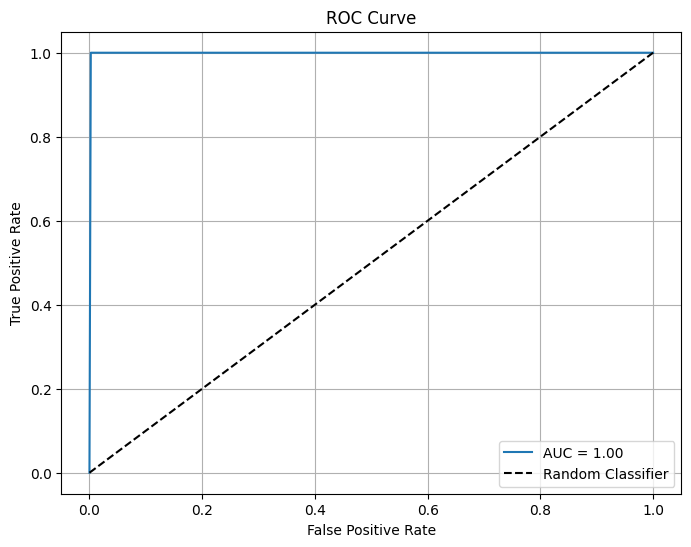

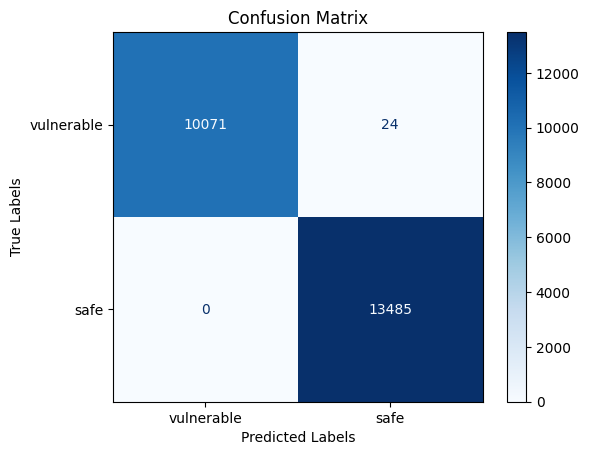

The Area Under Curve (AUC) is: 1.00


In [17]:
auc = calculate_auc_roc(model, test_loader, device)
plot_confusion_matrix(model, test_loader, device)
print(f'The Area Under Curve (AUC) is: {auc:.2f}')

In [18]:
adversarial_tokenized_dataset = load_from_disk(path+"Datasets/TransformedDataset/")

adversarial_train_dataset = adversarial_tokenized_dataset['train']
adversarial_val_dataset = adversarial_tokenized_dataset['validation']
adversarial_test_dataset = adversarial_tokenized_dataset['test']

batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
adversarial_train_loader = DataLoader(adversarial_train_dataset, batch_size=batch_size, shuffle=True)
adversarial_val_loader = DataLoader(adversarial_val_dataset, batch_size=batch_size, shuffle=True)
adversarial_test_loader = DataLoader(adversarial_test_dataset, batch_size=batch_size, shuffle=True)

In [19]:
adversarial_losses = test_model_adversarial(model, adversarial_test_loader, device, fp16=True)
adversarial_results = run_inference_and_collect_results_adversarial(model, adversarial_test_loader, device, fp16=True)

In [20]:
print("Adversarial Losses:")
print(f"Original Loss: {adversarial_losses['original_loss']:.4f}")
print(f"Similar Characters Loss: {adversarial_losses['similar_loss']:.4f}")
print(f"Case Symbols Loss: {adversarial_losses['case_symbols_loss']:.4f}")
print(f"Unicode Replacement Loss: {adversarial_losses['unicode_loss']:.4f}\n")

# Evaluate metrics for each type
for key in adversarial_results:
    predictions = adversarial_results[key]["predictions"]
    labels = adversarial_results[key]["labels"]

    accuracy = accuracy_score(labels, predictions) * 100
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    print(f"Results for {key.capitalize()} Inputs:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("\n")

Adversarial Losses:
Original Loss: 0.0058
Similar Characters Loss: 0.0104
Case Symbols Loss: 0.0056
Unicode Replacement Loss: 0.0162

Results for Original Inputs:
  Accuracy: 99.90%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Similar Inputs:
  Accuracy: 99.73%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Case symbols Inputs:
  Accuracy: 99.89%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Unicode Inputs:
  Accuracy: 99.50%
  Precision: 0.99
  Recall: 1.00
  F1 Score: 1.00


